In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import random
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ, primeX, primeY, primeZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [34]:
def run_ransac(data, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    best_ic = 0
    best_model = None
    random.seed(random_seed)
    # random.sample cannot deal with "data" being a numpy array
    data = list(data)
    for i in range(max_iterations):
        s = random.sample(data, int(sample_size))
        m = estimate(s)
        ic = 0
        for j in range(len(data)):
            if is_inlier(m, data[j]):
                ic += 1

        #print(s)
        #print('estimate:', m,)
        #print('# inliers:', ic)

        if ic > best_ic:
            best_ic = ic
            best_model = m
            if ic > goal_inliers and stop_at_goal:
                break
    #print('took iterations:', i+1, 'best model:', best_model, 'explains:', best_ic)
    return best_model, best_ic

def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold

def planeRotMat(a, b, c, d):
    """
    """
    
    cos = c/np.sqrt(a*a + b*b + d*d)
    sin = np.sqrt((a*a + b*b)/(a*a + b*b + d*d))
    u1 = b/np.sqrt(a*a + b*b + d*d)
    u2 = -a/np.sqrt(a*a + b*b + d*d)
    
    rot = np.matrix([[cos+u1*u1*(1-cos), u1*u2*(1-cos), u2*sin],
                     [u1*u2*(1-cos), cos+u2*u2*(1-cos), -u1*sin],
                     [-u2*sin, u1*sin, cos]])
    
    return rot

def alignPlane(x, y, z, a, b, c, d):
    """
    """
    
    rot = planeRotMat(a, b, c, d)
    xyzr = rot*np.matrix([x.flatten(),y.flatten(),z.flatten()])
    xr = np.array(xyzr[0]).reshape(x.shape)
    yr = np.array(xyzr[1]).reshape(y.shape)
    zr = np.array(xyzr[2]).reshape(z.shape)
    
    return xr, yr, zr

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask


def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg


def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [10]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0.]
kernel = Gaussian2DKernel(x_stddev=17.75)
iz = 4
izv = -518
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

CPU times: user 1min 25s, sys: 4.59 s, total: 1min 30s
Wall time: 1min 26s


In [7]:
%%time
sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
#sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_03:27:25.ptx.csv".format(scanDir) # C4=-167
#sigScan = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-562
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir) # C13=-169
#sigScan = "{0}/2020_03_16_06:18:53.ptx.csv".format(scanDir) # C13=-56
#sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) # C7=-545
#sigScan = "{0}/2020_03_16_04:41:09.ptx.csv".format(scanDir) # C7=-144
#sigScan = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) # C7=-554
xs, ys, zs = prepareData(sigScan, n=n, rot=178.)

CPU times: user 5.23 s, sys: 2.22 s, total: 7.46 s
Wall time: 3.22 s


In [8]:
xrg, yrg, zrg = xr, yr, zr
xsg, ysg, zsg = xs, ys, zs

In [9]:
%%time
zrgs = convolve(zrg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)

CPU times: user 10 s, sys: 7.85 ms, total: 10 s
Wall time: 10.1 s


In [11]:
zrsFit, zrsMask = parabolaFitIterations(xrg, yrg, zrgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

In [12]:
zsgs = convolve(zsg, kernel, boundary='extend', fill_value=0.0, nan_treatment='interpolate', 
                normalize_kernel=True, mask=None, preserve_nan=True, normalization_zero_tol=1e-08)

In [13]:
%%time
zssFit, zssMask = parabolaFitIterations(xsg, ysg, zsgs,
                                        guess=guess, bounds=None, iters=10, 
                                        max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 4min 41s, sys: 4min 8s, total: 8min 50s
Wall time: 24.1 s


In [14]:
print(zrsFit.x)
print(zssFit.x)

[ 6.00601972e+01  2.44724283e+00 -9.91700728e-01 -4.91923672e+01
  2.19793555e-01 -5.12147286e-03]
[ 6.00658279e+01  2.44798127e+00 -9.82928327e-01 -4.91911724e+01
  2.19692917e-01 -5.09351399e-03]


In [15]:
pFitR = np.copy(zrsFit.x)
pFitS = np.copy(zssFit.x)
#pFitR[3] = pFitS[3] = 0
#pFitR[1] = pFitR[2] = pFitR[3] = 0
#pFitS[1] = pFitS[2] = pFitS[3] = 0
#pFitR[4] = pFitR[5] = 0
#pFitS[4] = pFitS[5] = 0
#pFitR[5] = pFitS[5] = 0
print(pFitR)
print(pFitS)

[ 6.00601972e+01  2.44724283e+00 -9.91700728e-01 -4.91923672e+01
  2.19793555e-01 -5.12147286e-03]
[ 6.00658279e+01  2.44798127e+00 -9.82928327e-01 -4.91911724e+01
  2.19692917e-01 -5.09351399e-03]


In [16]:
%%time
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)
xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)

CPU times: user 237 ms, sys: 163 ms, total: 400 ms
Wall time: 25.6 ms


In [17]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 44.2 s, sys: 6.37 s, total: 50.6 s
Wall time: 41.5 s


<IPython.core.display.Javascript object>


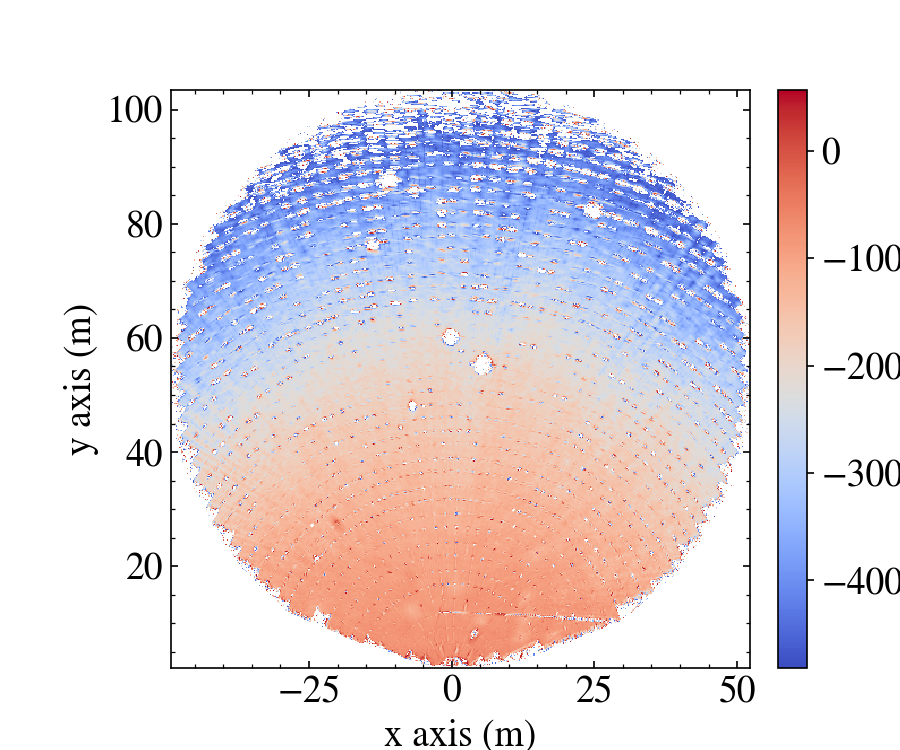

In [53]:
diff = sigma_clip(np.ma.masked_invalid(zsag - zrag))
#diff = np.ma.masked_where(zsMask | zrMask, diff)
diff = sigma_clip(diff, 2.5)
surfacePlot(xrag, yrag, diff.T*1e6, vMin=np.nanmin(diff*1e6), vMax=np.nanmax(diff*1e6), midPoint=np.nanmean(diff*1e6))

In [29]:
xyzs = np.vstack((xrag[~diff.mask], yrag[~diff.mask], diff[~diff.mask])).T
print(xyzs.shape)
sample = int(xyzs.shape[0] * 0.5)
goal_inliers = int(sample * 0.5)
max_iterations = 100

(193848, 3)


In [31]:
%%time
m, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, 1e-4), sample, goal_inliers, max_iterations)
a, b, c, d = m

CPU times: user 2min 49s, sys: 2.38 s, total: 2min 52s
Wall time: 2min 49s


In [45]:
a, b, c, d, np.sqrt(a*a + b*b + d*d)

(3.4222364912139173e-06,
 3.7204038977380376e-05,
 0.9999999630520103,
 0.0002692584735131028,
 0.00027183814628826194)

In [35]:
x_, y_, z_ = alignPlane(xrag, yrag, diff, a, b, c, d)

<IPython.core.display.Javascript object>


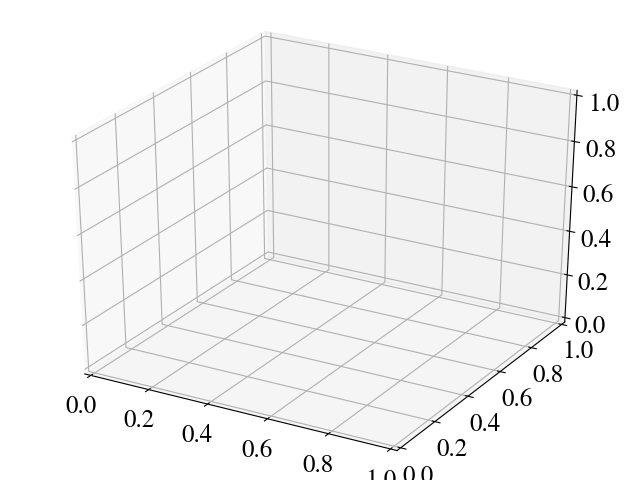

ValueError: Argument Z must be 2-dimensional.

In [54]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = mplot3d.Axes3D(fig)
ax.plot_surface(xrag[~diff.mask], yrag[~diff.mask], diff[~diff.mask], color=(0, 1, 0, 0.5))

In [40]:
z_ = np.ma.masked_where(diff.mask, z_)

<IPython.core.display.Javascript object>


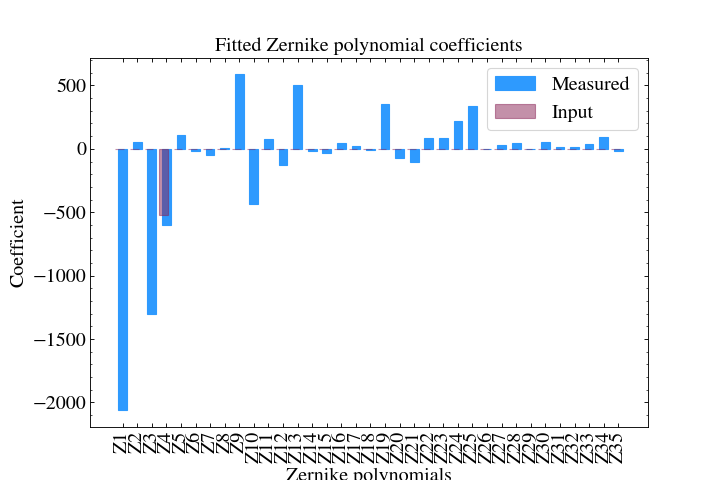

In [55]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


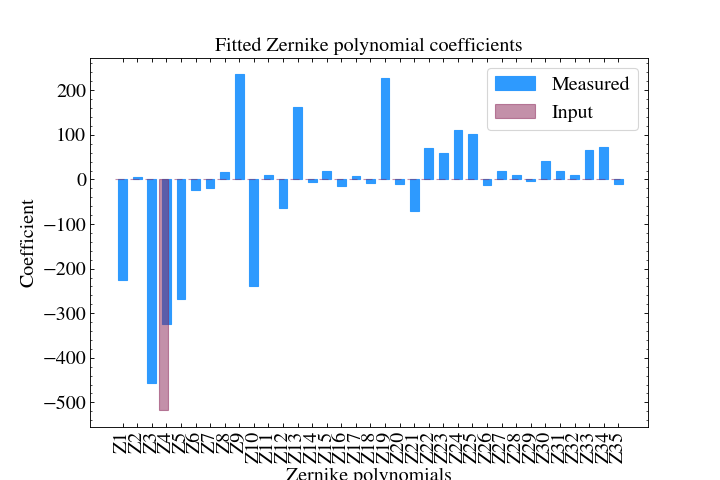

In [56]:
fl_fs_sub = np.copy(fl_fs)
fl_fs_sub[2] *= -1.
zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[0:4])
diff_ = diff - zpoly_
fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs_[1:36]*1e6, expected=zcoef[1:36])

In [57]:
fl_fs[4]*1e6, fl_fs_[4]*1e6

(-598.2210097821221, -323.77792307896516)

In [20]:
fl_fs[7]*1e6, fl_fs_[7]*1e6

(46.63234441016233, 47.870755244630615)

In [21]:
fl_fs[13]*1e6, fl_fs_[13]*1e6

(-627.1120878919039, -594.6528805369395)

In [22]:
# Ci's from March - October.
# Using the mask from the parabola fitter.
fl_diff = np.array([ 0.00000000e+00, -3.69288510e-03, -1.49139347e-05, -3.52637492e-03,
       -1.20384279e-03,  3.42504620e-04, -6.94333784e-05,  7.45391278e-05,
       -2.82334099e-04,  1.16525931e-03, -5.20602079e-04,  7.60481614e-05,
        1.18311862e-03,  1.32807415e-03, -1.31880599e-05,  2.32681778e-04,
       -1.04560218e-04, -2.81682910e-05,  4.20666148e-04,  6.30305870e-04,
        5.67510711e-04, -5.28192266e-04,  4.95492629e-04, -3.32781178e-04,
        4.04544300e-04,  1.03737866e-03,  1.47115401e-04, -3.54065880e-04,
       -8.38001315e-05,  5.29861377e-07,  4.91299950e-04, -8.66901157e-05,
       -1.52489921e-07,  6.29674463e-04,  1.86082374e-04,  1.90359416e-04,
        3.80229172e-04])
fl_diff_ = np.array([ 0.00000000e+00, -3.71682792e-03, -2.58358180e-03, -3.53105556e-03,
       -1.20566590e-03,  3.32335485e-04,  2.32908596e-04, -1.74258160e-05,
        6.81334059e-04,  1.18443492e-03, -5.05738044e-04,  8.65598384e-05,
        1.17520943e-03,  1.32925720e-03, -1.63907828e-04,  7.86179735e-05,
       -5.58908977e-05,  1.21431588e-04,  1.29821922e-03,  6.49889436e-04,
        5.64216358e-04, -5.14556665e-04,  4.96710125e-04, -2.91337239e-04,
        4.24701050e-04,  1.05750007e-03, -2.12268496e-05, -2.99363465e-04,
       -1.60039236e-04,  5.87575395e-05,  4.14361538e-04,  2.16738385e-06,
        7.72271937e-04,  6.51354892e-04,  1.96974470e-04,  2.07264460e-04,
        3.67381666e-04])

In [23]:
fl_diff = np.array([ 0.00000000e+00, -4.95066941e-03,  1.78990849e-04, -5.99716659e-03,
       -2.89161217e-04, -9.11323119e-04, -1.31885912e-05, -1.39847453e-04,
       -1.55114349e-04,  7.97151571e-04, -4.90269608e-04,  4.01070621e-04,
        5.87779993e-04,  7.49339935e-04, -2.38696729e-04,  1.78838369e-04,
        7.67140344e-05,  6.14181659e-05,  5.80052364e-04,  6.05003080e-04,
        3.27972954e-05, -7.81413338e-05,  5.99882342e-05, -1.03757820e-04,
        3.40930544e-04,  6.27484577e-04,  1.03829085e-04,  1.88756803e-06,
       -9.53187559e-05,  1.80298431e-05,  1.80692083e-04, -2.88046599e-04,
        2.60141989e-05,  6.34869244e-04,  9.62421357e-05,  4.56551029e-05,
        1.24674452e-04])
fl_diff_ = np.array([ 0.00000000e+00, -4.79423428e-03, -5.32398155e-03, -6.00016313e-03,
       -3.07888519e-04, -9.57284246e-04, -3.74535852e-05, -1.49184994e-04,
        6.28182959e-04,  8.18853488e-04, -4.76942360e-04,  4.32472011e-04,
        5.56862712e-04,  6.93640505e-04, -4.11982835e-04,  2.75246465e-05,
        1.16604493e-04,  1.98153847e-04,  1.53545303e-03,  6.52331555e-04,
        7.27764908e-05, -6.02058241e-05,  5.93541352e-05, -9.80896108e-05,
        3.00272224e-04,  5.79159840e-04, -1.37778391e-04, -6.20661561e-05,
       -2.18875209e-04,  2.69735536e-05,  2.03614890e-04, -1.35585651e-04,
        1.04023629e-03,  6.83742294e-04,  1.25574412e-04,  2.96015210e-05,
        1.04995170e-04])

In [24]:
(fl_fs[iz] - fl_diff[iz])*1e6, (fl_fs_[iz] - fl_diff_[iz])*1e6

(-1376.4520228919039, -1288.2933855369395)